In [1]:
from ase.io import read
import numpy as np
from pyace import PyACECalculator
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import gridspec
mpl.rcParams['figure.dpi'] = 150
plt.style.use('~/plot.mplstyle')
np.set_printoptions(threshold=np.inf)
cm=1/2.54
from matplotlib.ticker import ScalarFormatter

In [2]:
def get_ace_energies(frames, pot):
    ace_energies=[]
    # ace_forces=np.zeros((len(frames),3))

    for atoms in frames:
        atoms.calc=pot
        ace_energies.append(atoms.get_potential_energy(force_consistent=True)/len(atoms))
    
    ace_energies=np.asarray(ace_energies)

    return ace_energies

In [3]:
def get_ace_forces(frames, pot):
    ace_forces=[]
    # ace_forces=np.empty((len(frames)))

    for i in range(len(frames)):
        atoms=frames[i]
        atoms.calc=pot
        
        forces=atoms.get_forces()
        # print(forces)
        ace_forces.append(forces)

    ace_forces=np.vstack(ace_forces)
        
    return ace_forces

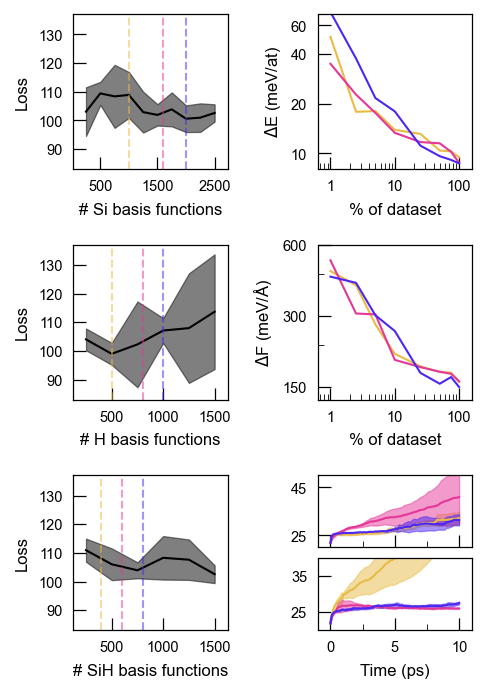

In [15]:
color='k'

elements=['Si','H', 'SiH']
n_funcs=np.arange(250,2750,250)

cheap_model=[1000,500,400]
medium_model=[1600,800,600]
expensive_model=[2000,1000,800]
colors=["#e9bb45","#e43799", "#4c27f2"]


df=pd.read_pickle('../../data/datasets/SCAN-SiH-GAP-22_training.pkl.gzip',compression="gzip")
frames=df.ase_atoms.values.tolist()
dft_energies=df.e_corrected_per_atom.values
dft_forces=df.forces.values
dft_forces = np.concatenate(dft_forces).ravel()

fig, axes= plt.subplots(3,2, figsize=(8.5*cm,12*cm))

for j in range(len(elements)):
    element=elements[j]
    rmse_e=np.zeros((5, len(n_funcs)))
    rmse_f=np.zeros((5, len(n_funcs)))
    

    for i in range(len(n_funcs)):
        nfunc=n_funcs[i]
        wdir=f'../../models/ablations/n_funcs/{element}/{element}_{nfunc}'
        # print(wdir)
        for sub in np.arange(1,6):
            try:
                try:
                    ace_energies=np.loadtxt(f'{wdir}/{sub}/GAP22_energy_preds.txt')

                except:
                    pot=PyACECalculator(f'{wdir}/{sub}/output_potential.yaml')
                    ace_energies=get_ace_energies(frames,pot)
                    np.savetxt(f'{wdir}/{sub}/GAP22_energy_preds.txt', ace_energies)

                rmse_e[sub-1,i]=np.sqrt(((dft_energies - ace_energies)**2).mean())*10**3

                try:
                    ace_forces=np.loadtxt(f'{wdir}/{sub}/GAP22_force_preds.txt')

                except:
                    pot=PyACECalculator(f'{wdir}/{sub}/output_potential.yaml')
                    ace_forces=get_ace_forces(frames, pot)
                    np.savetxt(f'{wdir}/{sub}/GAP22_force_preds.txt', ace_forces)

                ace_forces = np.concatenate(ace_forces).ravel()

                rmse_f[sub-1,i] = np.sqrt(np.mean((dft_forces - ace_forces)**2)) * 1e3

            except:
                continue


    combined_rmse = 0.5 * rmse_e + 0.5 * rmse_f
    combined_rmse_av=np.mean(combined_rmse, axis=0)
    combined_rmse_std=np.std(combined_rmse, axis=0)
    combined_rmse_argmin = np.argmin(combined_rmse, axis=0)

    rmse_e_min = [rmse_e[argm][i] for i, argm in enumerate(combined_rmse_argmin)]
    rmse_f_min = [rmse_f[argm][i] for i, argm in enumerate(combined_rmse_argmin)]

    rmse_loss_min=0.5*np.asarray(rmse_e_min)+0.5*np.asarray(rmse_f_min)

    axes[j,0].plot(n_funcs, combined_rmse_av, c=color)
    axes[j,0].fill_between(n_funcs, combined_rmse_av-combined_rmse_std, combined_rmse_av+combined_rmse_std, color=color, alpha=0.5)

    
    axes[j,0].set_ylabel("Loss")
    axes[j,0].set_xlabel(f"# {element} basis functions")

    axes[j,0].axvline(cheap_model[j], color=colors[0], linestyle='--', alpha=0.5)
    axes[j,0].axvline(medium_model[j], color=colors[1], linestyle='--', alpha=0.5)
    axes[j,0].axvline(expensive_model[j], color=colors[2], linestyle='--', alpha=0.5)
    axes[j,0].set_ylim(83,137)
    axes[j,0].set_yticks(np.arange(90,140, 10))

    n_funcs=np.arange(250,1750,250)

axes[0,0].set_xticks([500,1500,2500])

sizes=[1,2.5,5,10,25,50,75,100]
potdirs=['cheap', 'medium', 'expensive']

df=pd.read_pickle('../../data/datasets/SCAN-SiH-GAP-22_training.pkl.gzip',compression="gzip")
frames=df.ase_atoms.values.tolist()
dft_energies=df.e_corrected_per_atom.values
dft_forces=df.forces.values
dft_forces = np.concatenate(dft_forces).ravel()
train_sizes=[]

for potdir,color in zip(potdirs, colors):
    rmse_e=np.zeros((5, len(sizes)))
    rmse_f=np.zeros((5, len(sizes)))

    for i in range(len(sizes)):
        size=sizes[i]
        wdir=f'../../models/ablations/dataset/{potdir}/{size:.1f}pct'

        for sub in np.arange(1,6):
            try:
                try:
                    ace_energies=np.loadtxt(f'{wdir}/{sub}/GAP22_energy_preds.txt')

                except:
                    pot=PyACECalculator(f'{wdir}/{sub}/output_potential.yaml')
                    ace_energies=get_ace_energies(frames,pot)
                    np.savetxt(f'{wdir}/{sub}/GAP22_energy_preds.txt', ace_energies)

                rmse_e[sub-1,i]=np.sqrt(((dft_energies - ace_energies)**2).mean())*10**3

                try:
                    ace_forces=np.loadtxt(f'{wdir}/{sub}/GAP22_force_preds.txt')

                except:
                    pot=PyACECalculator(f'{wdir}/{sub}/output_potential.yaml')
                    ace_forces=get_ace_forces(frames, pot)
                    np.savetxt(f'{wdir}/{sub}/GAP22_force_preds.txt', ace_forces)

                ace_forces = np.concatenate(ace_forces).ravel()

                rmse_f[sub-1,i] = np.sqrt(np.mean((dft_forces - ace_forces)**2)) * 1e3

            except:
                continue

    combined_rmse = 0.5 * rmse_e + 0.5 * rmse_f
    combined_rmse_argmin = np.argmin(combined_rmse, axis=0)

    rmse_e_min = [rmse_e[argm][i] for i, argm in enumerate(combined_rmse_argmin)]
    rmse_f_min = [rmse_f[argm][i] for i, argm in enumerate(combined_rmse_argmin)]
    rmse_loss_min=0.5*np.asarray(rmse_e_min)+0.5*np.asarray(rmse_f_min)

    axes[0,1].plot(sizes, rmse_e_min, c=color, label=potdir)
    axes[0,1].set_ylabel("$\Delta$E (meV/at)")
    axes[0,1].set_xlabel("% of dataset")
    axes[0,1].loglog()
    axes[0,1].xaxis.set_major_formatter(ScalarFormatter())
    axes[0,1].yaxis.set_major_formatter(ScalarFormatter())
    axes[0,1].set_yticks([10, 20, 40, 60])
    axes[0,1].set_ylim(top=70)
    axes[0,1].set_yticks([], minor=True)

    axes[1,1].plot(sizes, rmse_f_min, c=color, label=potdir)
    axes[1,1].set_ylabel("$\Delta$F (meV/Å)")
    axes[1,1].set_xlabel("% of dataset")
    axes[1,1].set_xticks([0,25,50,75,100])
    axes[1,1].loglog()
    axes[1,1].xaxis.set_major_formatter(ScalarFormatter())
    axes[1,1].yaxis.set_major_formatter(ScalarFormatter())
    axes[1,1].set_yticks([150, 300, 600])
    axes[1,1].yaxis.set_minor_formatter(ScalarFormatter())
    axes[1,1].set_yticks([225, 450], minor=True)
    axes[1,1].set_yticklabels([], minor=True)


gs = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=axes[2,1].get_subplotspec(),
    height_ratios=[1, 1], hspace=0.15
)

models=['2300', '3600', '4600']
colors=["#4c27f2","#e43799","#e9bb45"][::-1]
repeat=np.arange(1,6)
time=np.arange(0, 10.1, 0.1)

axes[2,1].remove()

ax_top = fig.add_subplot(gs[0])
ax_bottom = fig.add_subplot(gs[1], sharex=ax_top)

for model, color in zip(models, colors):
    vols = np.zeros((5, 101))
    for i in repeat:
        traj = read(f'../../data/paper/ablations/symm/{model}/Hconc-50/{i}/dump_custom_pace', index='1:102')
        vols[i-1, :] = [atoms.get_cell()[0][0] for atoms in traj]

    av_vols = np.mean(vols, axis=0)
    std_vols = np.std(vols, axis=0)

    ax_top.plot(time, av_vols, label=model, c=color)
    ax_top.fill_between(time, av_vols-std_vols, av_vols+std_vols, color=color, alpha=0.5)

    vols = np.zeros((5, 101))
    for i in repeat:
        traj = read(f'../../data/paper/ablations/nosymm/{model}/Hconc-50/{i}/dump_custom_pace', index='1:102')
        vols[i-1, :] = [atoms.get_cell()[0][0] for atoms in traj]

    av_vols = np.mean(vols, axis=0)
    std_vols = np.std(vols, axis=0)

    ax_bottom.plot(time, av_vols, label=model, c=color)
    ax_bottom.fill_between(time, av_vols-std_vols, av_vols+std_vols, color=color, alpha=0.5)

ax_bottom.set_xlabel('Time (ps)')
ax_bottom.set_ylim(bottom=20, top=40)
ax_bottom.set_yticks(np.arange(25,45,10))
ax_bottom.set_xticks(np.arange(0, 15, 5))
ax_bottom.set_xticks(np.arange(0, 12.5, 2.5), minor=True)

ax_top.set_ylim(bottom=20, top=50)
ax_top.set_yticks(np.arange(25,65,20))

fig.tight_layout()
